In [1]:
# imports
from shapely import Point
from shapely import intersects
from shapely.geometry import shape, mapping
import matplotlib.pylab as plt
import numpy as np
import fiona
import pyproj
from shapely.ops import transform


In [2]:
# user inputs 
population_fn = "tl_2020_08_tabblock20/tl_2020_08_tabblock20_26913.shp"
center = Point(499949.3,4400390.4) # utm13N
num_bins = 100 # number of steps between zero and max_dist
max_dist = 20*1000 # m


In [3]:
# make radii, open population shapefile
rs = np.linspace(0, max_dist, num=num_bins)

with fiona.open(population_fn) as col:
    info = [(shape(feat['geometry']), feat['properties']['POP20']) for feat in col]


In [4]:
population = [np.nan]
cumulative_population = [0]
avg_population_density = [np.nan]
shell_population_density =[np.nan]
total_area = [0]
shell_area = [0]
circles = [None]
shells = [None]

for i, r in enumerate(rs[1:]):

    # buffer point
    buffered = center.buffer(r)
    
    # construct the shell between the two radii
    if i>0:
        shell = buffered.difference(circles[-1])
    else:
        shell = buffered
    
    # store geometry
    circles.append(buffered)
    shells.append(shell)
    
    # store areas
    total_area.append(buffered.area)
    shell_area.append(shell.area)
    
    # determine population in this shell
    pop = 0
    for shp, shp_pop in info:
        if intersects(shell, shp):      
            fraction = shell.intersection(shp).area/shp.area     
            pop += fraction*shp_pop
    
    # store populations
    population.append(pop)
    cumulative_population.append(cumulative_population[-1]+pop)
    
    # calculate population density
    avg_population_density.append(cumulative_population[-1]/total_area[-1])
    shell_population_density.append(pop/shell.area)
    
    print(f'SHELL {i}, cumulative pop: {cumulative_population[-1]}')

SHELL 0, cumulative pop: 1418.698205184006
SHELL 1, cumulative pop: 5256.140811356985
SHELL 2, cumulative pop: 10104.630244260346
SHELL 3, cumulative pop: 14155.494329394482
SHELL 4, cumulative pop: 19564.9833149232
SHELL 5, cumulative pop: 25221.82801816178
SHELL 6, cumulative pop: 30239.64971011485
SHELL 7, cumulative pop: 37370.77375801911
SHELL 8, cumulative pop: 47635.98249801011
SHELL 9, cumulative pop: 57455.81007552057
SHELL 10, cumulative pop: 65792.39990634157
SHELL 11, cumulative pop: 75739.55867165959
SHELL 12, cumulative pop: 86465.53279119065
SHELL 13, cumulative pop: 98680.72954851376
SHELL 14, cumulative pop: 111733.6639356205
SHELL 15, cumulative pop: 124478.50782588749
SHELL 16, cumulative pop: 137835.08601353696
SHELL 17, cumulative pop: 150330.52803571709
SHELL 18, cumulative pop: 160589.25519763632
SHELL 19, cumulative pop: 170460.96243765307
SHELL 20, cumulative pop: 182572.6471742704
SHELL 21, cumulative pop: 196580.93602280883
SHELL 22, cumulative pop: 211291.28

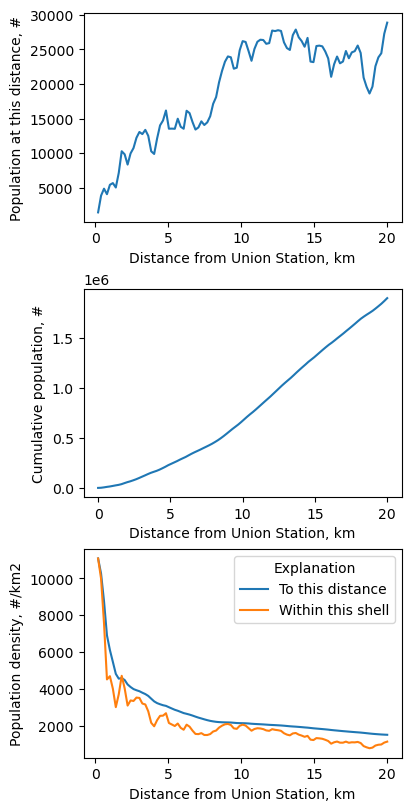

In [5]:
fig, axes = plt.subplots(figsize=(4,8),ncols=1, nrows=3, dpi=100, layout='constrained')

axes[0].plot(rs/1000, population)
axes[0].set_xlabel("Distance from Union Station, km")
axes[0].set_ylabel("Population at this distance, #")

axes[1].plot(rs/1000, cumulative_population)
axes[1].set_xlabel("Distance from Union Station, km")
axes[1].set_ylabel("Cumulative population, #")

axes[2].plot(rs/1000, np.array(avg_population_density)*1e6, label ='To this distance')
axes[2].plot(rs/1000, np.array(shell_population_density)*1e6, label="Within this shell")
axes[2].legend(title='Explanation')
axes[2].set_xlabel("Distance from Union Station, km")
axes[2].set_ylabel("Population density, #/km2")
fig.savefig("summary.png", dpi=300)

In [6]:
with fiona.open(population_fn) as src:
    driver = src.driver
    crs = src.crs
    
schema = {'geometry': 'Polygon',
 'properties': {'pop': 'float',
                'density': 'float',
}}
# shell density
with fiona.open("shells_20km.shp", "w", 
                driver=driver, crs=crs, 
                schema=schema) as dst:

    for i in range(1, len(shells)):
        feat = {'geometry':mapping(shells[i]),
                'properties':{'pop':population[i],
                            'density': shell_population_density[i]*1e6}}

        dst.write(feat)
        
# selected tracts, write out density
selection = center.buffer(max_dist*1.2)   
with fiona.open("tract_density_20km.shp", "w", 
                driver=driver, crs=crs, 
                schema=schema) as dst:

    for shp, shp_pop in info:
        if intersects(selection,shp):
            feat = {'geometry':mapping(shp),
                'properties':{'pop':shp_pop,
                            'density': shp_pop/shp.area*1e6}}
            dst.write(feat) 
            

In [7]:
shp=info[0][0]

In [8]:
shp.type

C:\Users\Chris\AppData\Local\Temp\ipykernel_8564\763504195.py:1: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  shp.type


'Polygon'